In [29]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [206]:
datos = pd.read_excel("Ventas Populares.xlsx", parse_dates=["Fecha"])
datos = datos.groupby(['Fecha', 'Sucursal', 'Producto']).agg({
    'Precio': 'mean',
    'Cantidad': 'sum',
    'Venta': 'sum',
    'Costo': 'sum'
}).reset_index()

In [207]:
# Generar un rango completo de fechas
all_dates = pd.date_range(start=datos['Fecha'].min(), end=datos['Fecha'].max())

# Obtener las combinaciones únicas de Sucursal, Producto
unique_combinations = datos[['Sucursal', 'Producto']].drop_duplicates()

# Crear un DataFrame para todas las fechas
all_dates_datos = pd.DataFrame(all_dates, columns=['Fecha'])

# Generar todas las combinaciones válidas de fechas con Sucursal, Categoría y Producto
all_combinations = unique_combinations.merge(all_dates_datos, how='cross')

# Combinar las combinaciones con los datos originales
full_datos = all_combinations.merge(datos, on=['Fecha', 'Sucursal', 'Producto'], how='left')

# Ordenar el DataFrame por Sucursal, Categoría, Producto y Fecha para el forward fill
full_datos = full_datos.sort_values(by=['Sucursal', 'Producto', 'Fecha'])

# Rellenar los valores NaN de Precio con el último precio conocido dentro de la jerarquía
full_datos['Precio'] = full_datos.groupby(['Sucursal', 'Producto'])['Precio'].fillna(method='ffill')

# Rellenar los valores NaN de Venta, Cantidad y Costo con 0
full_datos['Venta'].fillna(0, inplace=True)
full_datos['Cantidad'].fillna(0, inplace=True)
full_datos['Costo'].fillna(0, inplace=True)

# Rellenar los valores NaN restantes de Precio (si hay) con 0
full_datos['Precio'].fillna(0, inplace=True)

In [73]:
full_datos

Sucursal                    Producto      Fecha     Precio  Cantidad  \
33790   AGROFACIL           ALLECTUS GR 20 KG 2023-01-02     0.0000       0.0   
33791   AGROFACIL           ALLECTUS GR 20 KG 2023-01-03     0.0000       0.0   
33792   AGROFACIL           ALLECTUS GR 20 KG 2023-01-04     0.0000       0.0   
33793   AGROFACIL           ALLECTUS GR 20 KG 2023-01-05  1045.2195       1.0   
33794   AGROFACIL           ALLECTUS GR 20 KG 2023-01-06  1045.2195       0.0   
...           ...                         ...        ...        ...       ...   
89375  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-06-25     6.0000       0.0   
89376  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-06-26     6.0000       0.0   
89377  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-06-27     6.0000       0.0   
89378  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-06-28     6.0000       0.0   
89379  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-06-29     6.0000       0.0   

           Venta   Costo  
33790     0.0000    0.00  
33791     0.0000    0.00  
33792     0.0000    0.00  
33793  1045.2195  686.32  
33794     0.0000    0.00  
...          ...     ...  
89375     0.0000    0.00  
89376     0.0000    0.00  
89377     0.0000    0.00  
89378     0.0000    0.00  
89379     0.0000    0.00  

[117175 rows x 7 columns]

In [61]:
# Agregar características temporales
full_datos['Dia_semana'] = full_datos['Fecha'].dt.dayofweek
full_datos['Mes'] = full_datos['Fecha'].dt.month
full_datos['Año'] = full_datos['Fecha'].dt.year
full_datos['Ventas_acumuladas'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].cumsum()

# Calcular promedios móviles y desviaciones estándar
full_datos['Promedio_movil_venta_7d'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=7).mean().reset_index(level=[0,1], drop=True)
full_datos['Promedio_movil_venta_30d'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=30).mean().reset_index(level=[0,1], drop=True)
full_datos['Promedio_movil_venta_1a'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=365).mean().reset_index(level=[0,1], drop=True)
full_datos['Desviacion_venta_7d'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=7).std().reset_index(level=[0,1], drop=True)
full_datos['Desviacion_venta_30d'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=30).std().reset_index(level=[0,1], drop=True)
full_datos['Desviacion_venta_1a'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].rolling(window=365).std().reset_index(level=[0,1], drop=True)

# Crear columnas lag
full_datos['Venta_lag_1'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].shift(1)
full_datos['Venta_lag_7'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].shift(7)
full_datos['Venta_lag_1a'] = full_datos.groupby(['Sucursal', 'Producto'])['Venta'].shift(365)
full_datos['Costo_lag_1'] = full_datos.groupby(['Sucursal', 'Producto'])['Costo'].shift(1)
full_datos['Costo_lag_7'] = full_datos.groupby(['Sucursal', 'Producto'])['Costo'].shift(7)
full_datos['Costo_lag_365'] = full_datos.groupby(['Sucursal', 'Producto'])['Costo'].shift(365)
full_datos['Cantidad_lag_1'] = full_datos.groupby(['Sucursal', 'Producto'])['Cantidad'].shift(1)
full_datos['Cantidad_lag_7'] = full_datos.groupby(['Sucursal', 'Producto'])['Cantidad'].shift(7)
full_datos['Cantidad_lag_365'] = full_datos.groupby(['Sucursal', 'Producto'])['Cantidad'].shift(365)

# Crear columnas basadas en datos del año pasado
full_datos['Costo_ano_pasado'] = full_datos.groupby(['Sucursal', 'Producto'])['Costo'].shift(365)
full_datos['Cantidad_ano_pasado'] = full_datos.groupby(['Sucursal', 'Producto'])['Cantidad'].shift(365)

# Crear ratios y promedios históricos
full_datos['Ratio_venta_precio'] = full_datos['Venta'] / full_datos['Precio']
full_datos['Promedio_historico_costo'] = full_datos.groupby(['Sucursal', 'Producto'])['Costo'].transform('mean')
full_datos['Cantidad_historico_costo'] = full_datos.groupby(['Sucursal', 'Producto'])['Cantidad'].transform('mean')

# Mostrar las primeras filas del DataFrame para verificar
full_datos.head()
# Filtrar datos relevantes y eliminar filas con valores faltantes
full_datos = full_datos.dropna()


In [24]:
full_datos.head()

Sucursal           Producto      Fecha     Precio  Cantidad  \
33790  AGROFACIL  ALLECTUS GR 20 KG 2023-01-02     0.0000       0.0   
33791  AGROFACIL  ALLECTUS GR 20 KG 2023-01-03     0.0000       0.0   
33792  AGROFACIL  ALLECTUS GR 20 KG 2023-01-04     0.0000       0.0   
33793  AGROFACIL  ALLECTUS GR 20 KG 2023-01-05  1045.2195       1.0   
33794  AGROFACIL  ALLECTUS GR 20 KG 2023-01-06  1045.2195       0.0   

           Venta   Costo  Dia_semana  Mes   Año  ...  Desviacion_venta_1a  \
33790     0.0000    0.00           0    1  2023  ...                  NaN   
33791     0.0000    0.00           1    1  2023  ...                  NaN   
33792     0.0000    0.00           2    1  2023  ...                  NaN   
33793  1045.2195  686.32           3    1  2023  ...                  NaN   
33794     0.0000    0.00           4    1  2023  ...                  NaN   

       Venta_lag_1  Venta_lag_7  Venta_lag_1a  Costo_lag_1  Costo_lag_7  \
33790          NaN          NaN           NaN          NaN          NaN   
33791       0.0000          NaN           NaN         0.00          NaN   
33792       0.0000          NaN           NaN         0.00          NaN   
33793       0.0000          NaN           NaN         0.00          NaN   
33794    1045.2195          NaN           NaN       686.32          NaN   

       Costo_lag_365  Costo_ano_pasado  Ratio_venta_precio  \
33790            NaN               NaN                 NaN   
33791            NaN               NaN                 NaN   
33792            NaN               NaN                 NaN   
33793            NaN               NaN                 1.0   
33794            NaN               NaN                 0.0   

       Promedio_historico_costo  
33790                 42.454887  
33791                 42.454887  
33792                 42.454887  
33793                 42.454887  
33794                 42.454887  

[5 rows x 26 columns]

In [40]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

# Inicializar un diccionario para almacenar resultados
resultados = {}

# Función para preparar datos para LSTM
def create_lstm_data(X, y, lookback=30):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - lookback):
        X_lstm.append(X[i:(i + lookback)])
        y_lstm.append(y[i + lookback])
    return np.array(X_lstm), np.array(y_lstm)

# Función para ajustar valores negativos a cero
def adjust_negative_values(preds):
    return np.maximum(preds, 0)

# Iterar por cada combinación de "Sucursal" y "Producto"
for (sucursal, producto), grupo in full_datos.groupby(['Sucursal', 'Producto']):
    # Dividir en conjuntos de entrenamiento y prueba
    train_data = grupo[grupo['Fecha'] < '2024-04-01']
    test_data = grupo[grupo['Fecha'] >= '2024-04-01']
    
    if len(train_data) == 0 or len(test_data) == 0:  # Saltar si no hay datos de entrenamiento o prueba para este grupo
        continue
    
    X_train = train_data.drop(columns=['Costo', 'Fecha', 'Sucursal', 'Producto'])
    y_train = train_data['Costo']
    X_test = test_data.drop(columns=['Costo', 'Fecha', 'Sucursal', 'Producto'])
    y_test = test_data['Costo']
    
    # Estandarizar los datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # LightGBM
    lgbm = LGBMRegressor()
    lgbm.fit(X_train_scaled, y_train)
    lgbm_preds = lgbm.predict(X_test_scaled)
    lgbm_preds = adjust_negative_values(lgbm_preds)
    lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
    
    # XGBoost
    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    xgb_preds = xgb.predict(X_test_scaled)
    xgb_preds = adjust_negative_values(xgb_preds)
    xgb_mae = mean_absolute_error(y_test, xgb_preds)
    
    # LSTM
    X_train_lstm, y_train_lstm = create_lstm_data(X_train_scaled, y_train.values, lookback=30)
    X_test_lstm, y_test_lstm = create_lstm_data(X_test_scaled, y_test.values, lookback=30)
    
    if len(X_train_lstm) == 0 or len(X_test_lstm) == 0:  # Saltar si no hay suficientes datos para LSTM
        continue
    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))
    
    lstm_preds = model.predict(X_test_lstm)
    lstm_preds = adjust_negative_values(lstm_preds)
    lstm_mae = mean_absolute_error(y_test_lstm, lstm_preds)
    
    # Almacenar resultados
    resultados[(sucursal, producto)] = {
        'LightGBM MAE': lgbm_mae,
        'XGBoost MAE': xgb_mae,
        'LSTM MAE': lstm_mae
    }

# Mostrar resultados
for key, value in resultados.items():
    print(f'Sucursal-Producto: {key}')
    for model, mae in value.items():
        print(f'{model}: {mae}')
    print('-----')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 7
[LightGBM] [Info] Start training from score 40.553562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [197]:
# Inicializar diccionario para almacenar predicciones futuras
futuras_predicciones = {}

# Obtener las características usadas para el ajuste
feature_columns = list(full_datos.drop(columns=['Costo', 'Cantidad', 'Fecha', 'Sucursal', 'Producto']).columns)

# Iterar por cada combinación de "Sucursal" y "Producto"
for (sucursal, producto), grupo in full_datos.groupby(['Sucursal', 'Producto']):
    grupo.set_index('Fecha', inplace=True)
    
    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(grupo['Cantidad'], model='additive', period=30)  # Ajustar el periodo según los datos
    
    # Extraer componentes
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal
    resid = decomposition.resid.dropna()
    
    # Preparar datos para modelos
    trend_df = trend.reset_index()
    trend_df['DayOfYear'] = trend_df['Fecha'].dt.dayofyear
    trend_df.rename(columns={'trend': 'Cantidad'}, inplace=True)
    
    seasonal_df = seasonal.reset_index()
    seasonal_df['DayOfYear'] = seasonal_df['Fecha'].dt.dayofyear
    seasonal_df.rename(columns={'seasonal': 'Cantidad'}, inplace=True)
    
    resid_df = resid.reset_index()
    resid_df.rename(columns={'resid': 'Cantidad'}, inplace=True)
    
    # Modelar la tendencia
    X_trend = trend_df[['DayOfYear']]
    y_trend = trend_df['Cantidad']
    
    trend_model = XGBRegressor()
    trend_model.fit(X_trend, y_trend)
    
    # Modelar la estacionalidad
    X_seasonal = seasonal_df[['DayOfYear']]
    y_seasonal = seasonal_df['Cantidad']
    
    seasonal_model = XGBRegressor()
    seasonal_model.fit(X_seasonal, y_seasonal)
    
    # Modelar los residuos
    X_resid = resid_df[['Fecha']]
    X_resid['Lag1'] = resid_df['Cantidad'].shift(1)
    X_resid = X_resid.dropna()
    y_resid = resid_df.loc[X_resid.index, 'Cantidad']
    
    resid_model = XGBRegressor()
    resid_model.fit(X_resid[['Lag1']], y_resid)
    
    # Preparar datos para predicción de los próximos 90 días
    last_known_date = grupo.index.max()
    future_dates = pd.date_range(last_known_date, periods=91, freq='D')[1:]
    
    future_data = pd.DataFrame({
        'Fecha': future_dates,
        'DayOfYear': future_dates.dayofyear
    })

    future_data['Tendencia'] = trend_model.predict(future_data[['DayOfYear']])
    future_data['Estacionalidad'] = seasonal_model.predict(future_data[['DayOfYear']])
    
    future_data['Residuo'] = np.nan
    
    # Predicción iterativa de los residuos
    last_resid = resid_df['Cantidad'].iloc[-1]
    for i in range(90):
        if i == 0:
            future_data.at[i, 'Residuo'] = resid_model.predict([[last_resid]])[0]
        else:
            future_data.at[i, 'Residuo'] = resid_model.predict([[future_data.at[i-1, 'Residuo']]])[0]
    
    future_data['Cantidad'] = future_data['Tendencia'] + future_data['Estacionalidad'] + future_data['Residuo']
    future_data['Cantidad'] = future_data['Cantidad'].apply(lambda x: 0 if x < 0 else round(x, 0))  # Asegurar que los Cantidads sean mayores que el mínimo histórico
    
    futuras_predicciones[(sucursal, producto)] = future_data

    # Imprimir las predicciones de los primeros 10 días
    print(f'Predicciones para Sucursal: {sucursal}, Producto: {producto}')
    print(future_data[['Fecha', 'Cantidad']].head(10))
    print('-----')
    
    # # Graficar comportamiento histórico y predicciones
    # plt.figure(figsize=(14, 7))
    # plt.plot(grupo.index, grupo['Cantidad'], label='Histórico')
    # plt.plot(future_data['Fecha'], future_data['Cantidad'], label='Predicción', linestyle='dashed')
    # plt.title(f'Predicción de Cantidads para {sucursal} - {producto}')
    # plt.xlabel('Fecha')
    # plt.ylabel('Cantidad')
    # plt.legend()
    # plt.show()

# Crear DataFrame para almacenar todas las predicciones
all_predictions = pd.DataFrame()

for (sucursal, producto), future_data in futuras_predicciones.items():
    future_data['Sucursal'] = sucursal
    future_data['Producto'] = producto
    future_data['Predicción_Cantidad'] = future_data['Cantidad']
    all_predictions = pd.concat([all_predictions, future_data[['Fecha', 'Sucursal', 'Producto', 'Cantidad']]])

# Guardar las predicciones en un archivo Excel
all_predictions.to_excel('predicciones_futuras_Cantidad.xlsx', index=False)

Predicciones para Sucursal: AGROFACIL, Producto: ALLECTUS GR 20 KG
       Fecha  Cantidad
0 2024-06-30       0.0
1 2024-07-01       0.0
2 2024-07-02       0.0
3 2024-07-03       0.0
4 2024-07-04       0.0
5 2024-07-05       0.0
6 2024-07-06       0.0
7 2024-07-07       0.0
8 2024-07-08       0.0
9 2024-07-09       0.0
-----
Predicciones para Sucursal: AGROFACIL, Producto: DEMAND DUO 240 ML
       Fecha  Cantidad
0 2024-06-30       0.0
1 2024-07-01       0.0
2 2024-07-02       0.0
3 2024-07-03       0.0
4 2024-07-04       0.0
5 2024-07-05       0.0
6 2024-07-06       0.0
7 2024-07-07       0.0
8 2024-07-08       0.0
9 2024-07-09       0.0
-----
Predicciones para Sucursal: AGROFACIL, Producto: FAENA FUERTE 360 LTO
       Fecha  Cantidad
0 2024-06-30       1.0
1 2024-07-01       0.0
2 2024-07-02       1.0
3 2024-07-03       1.0
4 2024-07-04       1.0
5 2024-07-05       1.0
6 2024-07-06       0.0
7 2024-07-07       2.0
8 2024-07-08       0.0
9 2024-07-09       1.0
-----
Predicciones para S

In [212]:
full_datos.to_excel('full_datos.xlsx', index=False)

In [221]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

# Leer datos
full_datos = pd.read_excel('full_datos.xlsx')
full_datos['Fecha'] = pd.to_datetime(full_datos['Fecha'])

# Función para agregar características de retraso (lags) y medias móviles
def agregar_caracteristicas(df):
    df['Lag1'] = df['Cantidad'].shift(1)
    df['Lag7'] = df['Cantidad'].shift(7)
    df['Lag30'] = df['Cantidad'].shift(30)
    df['Lag60'] = df['Cantidad'].shift(60)
    df['RollingMean7'] = df['Cantidad'].rolling(window=7).mean()
    df['RollingMean30'] = df['Cantidad'].rolling(window=30).mean()
    df['Diff1'] = df['Cantidad'].diff(1)
    df['Diff7'] = df['Cantidad'].diff(7)
    df['Diff30'] = df['Cantidad'].diff(30)
    df['DayOfYear'] = df['Fecha'].dt.dayofyear
    df['Month'] = df['Fecha'].dt.month
    df['WeekOfYear'] = df['Fecha'].dt.isocalendar().week
    df['DayOfWeek'] = df['Fecha'].dt.dayofweek
    return df

# Iterar 90 veces para predecir los próximos 90 días
for _ in range(90):
    # Obtener la máxima fecha actual
    max_fecha = full_datos['Fecha'].max()
    
    # Filtrar datos hasta la máxima fecha
    datos_hasta_max_fecha = full_datos[full_datos['Fecha'] <= max_fecha]

    # Agregar características a los datos
    datos_hasta_max_fecha = agregar_caracteristicas(datos_hasta_max_fecha)
    
    futuras_predicciones = []

    # Iterar por cada combinación de "Sucursal" y "Producto"
    for (sucursal, producto), grupo in datos_hasta_max_fecha.groupby(['Sucursal', 'Producto']):
        grupo = grupo.dropna()  # Eliminar filas con valores faltantes después de agregar características

        # Preparar datos para el modelo
        X = grupo[['DayOfYear', 'Lag1', 'Lag7', 'Lag30', 'Lag60', 'RollingMean7', 'RollingMean30', 'Diff1', 'Diff7', 'Diff30', 'Month', 'WeekOfYear', 'DayOfWeek']]
        y = grupo['Cantidad']

        # Escalar los datos
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Entrenar el modelo
        model = XGBRegressor()
        model.fit(X_scaled, y)

        # Preparar características para el siguiente día
        new_date = max_fecha + pd.Timedelta(days=1)
        last_row = grupo.iloc[-1]
        new_row = {
            'Fecha': new_date,
            'DayOfYear': new_date.dayofyear,
            'Month': new_date.month,
            'WeekOfYear': new_date.isocalendar().week,
            'DayOfWeek': new_date.dayofweek,
            'Lag1': last_row['Cantidad'],
            'Lag7': grupo.iloc[-7]['Cantidad'] if len(grupo) >= 7 else np.nan,
            'Lag30': grupo.iloc[-30]['Cantidad'] if len(grupo) >= 30 else np.nan,
            'Lag60': grupo.iloc[-60]['Cantidad'] if len(grupo) >= 60 else np.nan,
            'RollingMean7': grupo['Cantidad'].rolling(window=7).mean().iloc[-1],
            'RollingMean30': grupo['Cantidad'].rolling(window=30).mean().iloc[-1],
            'Diff1': last_row['Cantidad'] - grupo.iloc[-2]['Cantidad'],
            'Diff7': last_row['Cantidad'] - grupo.iloc[-8]['Cantidad'] if len(grupo) >= 8 else np.nan,
            'Diff30': last_row['Cantidad'] - grupo.iloc[-31]['Cantidad'] if len(grupo) >= 31 else np.nan
        }
        new_row = pd.DataFrame([new_row])

        # Escalar las nuevas características
        X_new = new_row[['DayOfYear', 'Lag1', 'Lag7', 'Lag30', 'Lag60', 'RollingMean7', 'RollingMean30', 'Diff1', 'Diff7', 'Diff30', 'Month', 'WeekOfYear', 'DayOfWeek']]
        X_new_scaled = scaler.transform(X_new)

        # Predecir la cantidad para el siguiente día
        prediccion = model.predict(X_new_scaled)
        
        # Asegurar que la predicción no sea negativa y redondear a 0 decimales
        prediccion = round(max(prediccion[0], 0), 0)

        # Almacenar predicción
        futuras_predicciones.append({
            'Fecha': new_date,
            'Sucursal': sucursal,
            'Producto': producto,
            'Cantidad': prediccion
        })

        # Imprimir la predicción
        print(f'Predicción para Sucursal: {sucursal}, Producto: {producto}, Fecha: {new_date.date()} -> Cantidad: {prediccion}')

    # Crear DataFrame para las predicciones futuras
    predicciones_df = pd.DataFrame(futuras_predicciones)

    # Concatenar predicciones con full_datos
    full_datos = pd.concat([full_datos, predicciones_df], ignore_index=True)

# Guardar el DataFrame actualizado en un nuevo archivo Excel
full_datos.to_excel('full_datos_actualizado.xlsx', index=False)


Predicción para Sucursal: AGROFACIL, Producto: ALLECTUS GR 20 KG, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: DEMAND DUO 240 ML, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: FAENA FUERTE 360 LTO, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: FAENA FUERTE DE 10 LTS, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: FAENA LTO., Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: MAXFORCE 30 GR, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: RYE GRASS PERENE PHD 50 LBS.22.68 KG, Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: STORM CUBETA.(10 KG), Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: STORM KG., Fecha: 2024-06-30 -> Cantidad: 0.0
Predicción para Sucursal: AGROFACIL, Producto: TERMIDOR (250 ML), Fecha: 2024-0

In [181]:
# Inicializar diccionario para almacenar predicciones futuras
futuras_predicciones = {}

full_datos['Costo_Unitario'] = np.where(full_datos['Cantidad'] > 0,
                                        full_datos['Costo'] / full_datos['Cantidad'],
                                        0)

# Obtener las características usadas para el ajuste
feature_columns = list(full_datos.drop(columns=['Costo', 'Cantidad', 'Costo_Unitario', 'Fecha', 'Sucursal', 'Producto']).columns)

# Iterar por cada combinación de "Sucursal" y "Producto"
for (sucursal, producto), grupo in full_datos.groupby(['Sucursal', 'Producto']):
    grupo.set_index('Fecha', inplace=True)
    
    min_historico_costo = grupo[grupo['Costo_Unitario'] > 0]['Costo_Unitario'].min()
    
    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(grupo['Costo_Unitario'], model='additive', period=30)  # Ajustar el periodo según los datos
    
    # Extraer componentes
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal
    resid = decomposition.resid.dropna()
    
    # Preparar datos para modelos
    trend_df = trend.reset_index()
    trend_df['DayOfYear'] = trend_df['Fecha'].dt.dayofyear
    trend_df.rename(columns={'trend': 'Costo_Unitario'}, inplace=True)
    
    seasonal_df = seasonal.reset_index()
    seasonal_df['DayOfYear'] = seasonal_df['Fecha'].dt.dayofyear
    seasonal_df.rename(columns={'seasonal': 'Costo_Unitario'}, inplace=True)
    
    resid_df = resid.reset_index()
    resid_df.rename(columns={'resid': 'Costo_Unitario'}, inplace=True)
    
    # Modelar la tendencia
    X_trend = trend_df[['DayOfYear']]
    y_trend = trend_df['Costo_Unitario']
    
    trend_model = XGBRegressor()
    trend_model.fit(X_trend, y_trend)
    
    # Modelar la estacionalidad
    X_seasonal = seasonal_df[['DayOfYear']]
    y_seasonal = seasonal_df['Costo_Unitario']
    
    seasonal_model = XGBRegressor()
    seasonal_model.fit(X_seasonal, y_seasonal)
    
    # Modelar los residuos
    X_resid = resid_df[['Fecha']]
    X_resid['Lag1'] = resid_df['Costo_Unitario'].shift(1)
    X_resid = X_resid.dropna()
    y_resid = resid_df.loc[X_resid.index, 'Costo_Unitario']
    
    resid_model = XGBRegressor()
    resid_model.fit(X_resid[['Lag1']], y_resid)
    
    # Preparar datos para predicción de los próximos 90 días
    last_known_date = grupo.index.max()
    future_dates = pd.date_range(last_known_date, periods=91, freq='D')[1:]
    
    future_data = pd.DataFrame({
        'Fecha': future_dates,
        'DayOfYear': future_dates.dayofyear
    })

    future_data['Tendencia'] = trend_model.predict(future_data[['DayOfYear']])
    future_data['Estacionalidad'] = seasonal_model.predict(future_data[['DayOfYear']])
    
    future_data['Residuo'] = np.nan
    
    # Predicción iterativa de los residuos
    last_resid = resid_df['Costo_Unitario'].iloc[-1]
    for i in range(90):
        if i == 0:
            future_data.at[i, 'Residuo'] = resid_model.predict([[last_resid]])[0]
        else:
            future_data.at[i, 'Residuo'] = resid_model.predict([[future_data.at[i-1, 'Residuo']]])[0]
    
    future_data['Costo_Unitario'] = future_data['Tendencia'] + future_data['Estacionalidad'] + future_data['Residuo']
    future_data['Costo_Unitario'] = future_data['Costo_Unitario'].apply(lambda x: 0 if x < min_historico_costo*0.8 else round(x, 2))  # Asegurar que los Cantidads sean mayores que el mínimo histórico
    
    futuras_predicciones[(sucursal, producto)] = future_data

    # Imprimir las predicciones de los primeros 10 días
    print(f'Predicciones para Sucursal: {sucursal}, Producto: {producto}')
    print(future_data[['Fecha', 'Costo_Unitario']].head(10))
    print('-----')
    
    # # Graficar comportamiento histórico y predicciones
    # plt.figure(figsize=(14, 7))
    # plt.plot(grupo.index, grupo['Cantidad'], label='Histórico')
    # plt.plot(future_data['Fecha'], future_data['Cantidad'], label='Predicción', linestyle='dashed')
    # plt.title(f'Predicción de Cantidads para {sucursal} - {producto}')
    # plt.xlabel('Fecha')
    # plt.ylabel('Cantidad')
    # plt.legend()
    # plt.show()

# Crear DataFrame para almacenar todas las predicciones
all_predictions = pd.DataFrame()

for (sucursal, producto), future_data in futuras_predicciones.items():
    future_data['Sucursal'] = sucursal
    future_data['Producto'] = producto
    all_predictions = pd.concat([all_predictions, future_data[['Fecha', 'Sucursal', 'Producto', 'Costo_Unitario']]])

# Guardar las predicciones en un archivo Excel
all_predictions.to_excel('predicciones_futuras_Costo_Unitario.xlsx', index=False)

Predicciones para Sucursal: AGROFACIL, Producto: ALLECTUS GR 20 KG
       Fecha  Costo_Unitario
0 2024-06-30               0
1 2024-07-01               0
2 2024-07-02               0
3 2024-07-03               0
4 2024-07-04               0
5 2024-07-05               0
6 2024-07-06               0
7 2024-07-07               0
8 2024-07-08               0
9 2024-07-09               0
-----
Predicciones para Sucursal: AGROFACIL, Producto: DEMAND DUO 240 ML
       Fecha  Costo_Unitario
0 2024-06-30               0
1 2024-07-01               0
2 2024-07-02               0
3 2024-07-03               0
4 2024-07-04               0
5 2024-07-05               0
6 2024-07-06               0
7 2024-07-07               0
8 2024-07-08               0
9 2024-07-09               0
-----
Predicciones para Sucursal: AGROFACIL, Producto: FAENA FUERTE 360 LTO
       Fecha  Costo_Unitario
0 2024-06-30               0
1 2024-07-01               0
2 2024-07-02               0
3 2024-07-03               0
4

In [223]:
# Cargar las predicciones de costos y cantidades
predicciones_costos = pd.read_excel('predicciones_futuras.xlsx')
predicciones_costos_unitarios = pd.read_excel('predicciones_futuras_Costo_Unitario.xlsx')
predicciones_cantidad = pd.read_excel('predicciones_futuras_Cantidad.xlsx')
full_datos = pd.read_excel('full_datos.xlsx')

In [224]:
# Combinar las predicciones de costos y cantidades
predicciones = predicciones_costos_unitarios.merge(predicciones_cantidad, on=['Fecha', 'Sucursal', 'Producto'], suffixes=('_Costo', '_Cantidad'))
# Ajustar los nombres de las columnas para la combinación final
predicciones = predicciones.rename(columns={'Costo_Unitario': 'Costo'})
predicciones['Costo'] = predicciones.apply(lambda row: 0 if row['Cantidad'] == 0 else row['Costo'], axis=1)
predicciones['Cantidad'] = predicciones.apply(lambda row: 0 if row['Costo'] == 0 else row['Cantidad'], axis=1)
predicciones['Costo_Unitario'] = predicciones['Costo']
predicciones['Costo'] = predicciones['Costo'] * predicciones['Cantidad']


# Combinar las predicciones con los datos originales
full_datos_combinados = pd.concat([full_datos, predicciones], ignore_index=True)
print(f'full_datos: {len(full_datos)}')
print(f'full_datos_combinados: {len(full_datos_combinados)}')
print(f'predicciones: {len(predicciones)}')

full_datos: 117175
full_datos_combinados: 136525
predicciones: 19350


In [225]:
def reemplazar_precio_cero(grupo):
    ultimo_precio = np.nan
    ultimo_costo = np.nan
    grupo = grupo.sort_values(by='Fecha')
    for i in range(len(grupo)):
        if grupo.iloc[i]['Costo_Unitario'] > 0:
            ultimo_costo = grupo.iloc[i]['Costo_Unitario']

        if grupo.iloc[i]['Fecha'] >= pd.to_datetime('2024-06-30'):
            if grupo.iloc[i]['Costo_Unitario'] == 0:
                if grupo.iloc[i]['Cantidad'] > 0:
                    grupo.at[grupo.index[i], 'Costo_Unitario'] = ultimo_costo
                    grupo.at[grupo.index[i], 'Costo'] = ultimo_costo * grupo.iloc[i]['Cantidad']

        if grupo.iloc[i]['Precio'] > 0:
            ultimo_precio = grupo.iloc[i]['Precio']
        elif grupo.iloc[i]['Precio'] == 0:
            if grupo.iloc[i]['Fecha'] < pd.to_datetime('2024-06-30'):
                # Buscar el primer precio futuro diferente de 0
                futuro_precio = grupo.iloc[i + 1:]['Precio'].loc[grupo.iloc[i + 1:]['Precio'] > 0]
                if not futuro_precio.empty:
                    grupo.at[grupo.index[i], 'Precio'] = futuro_precio.iloc[0]
            else:
                # Usar el último precio previo
                if not np.isnan(ultimo_precio):
                    grupo.at[grupo.index[i], 'Precio'] = ultimo_precio
    return grupo

def calcular_costo_grupo(grupo):
    ultimo_costo = np.nan
    grupo = grupo.sort_values(by='Fecha')
    for i in range(len(grupo)):
        if grupo.iloc[i]['Costo_Unitario'] > 0:
            ultimo_costo = grupo.iloc[i]['Costo_Unitario']

        if grupo.iloc[i]['Fecha'] >= pd.to_datetime('2024-06-30'):
            if grupo.iloc[i]['Costo_Unitario'] == 0:
                if grupo.iloc[i]['Cantidad'] > 0:
                    grupo.at[grupo.index[i], 'Costo_Unitario'] = ultimo_costo
                    grupo.at[grupo.index[i], 'Costo'] = ultimo_costo * grupo.iloc[i]['Cantidad']
    return grupo

full_datos_combinados = full_datos_combinados.sort_values(by=['Sucursal', 'Producto', 'Fecha'])

full_datos_combinados['Precio'] = full_datos_combinados.apply(lambda row: 0 if np.isnan(row['Precio']) else row['Precio'], axis=1)

full_datos_combinados = full_datos_combinados.groupby(['Sucursal', 'Producto']).apply(reemplazar_precio_cero)

# Guardar el resultado en un nuevo archivo CSV
full_datos_combinados.to_excel('full_datos_combinados.xlsx', index=False)

# Verificar los primeros registros del nuevo DataFrame
print(full_datos_combinados.head())

                                Sucursal           Producto      Fecha  \
Sucursal  Producto                                                       
AGROFACIL ALLECTUS GR 20 KG 0  AGROFACIL  ALLECTUS GR 20 KG 2023-01-02   
                            1  AGROFACIL  ALLECTUS GR 20 KG 2023-01-03   
                            2  AGROFACIL  ALLECTUS GR 20 KG 2023-01-04   
                            3  AGROFACIL  ALLECTUS GR 20 KG 2023-01-05   
                            4  AGROFACIL  ALLECTUS GR 20 KG 2023-01-06   

                                  Precio  Cantidad      Venta   Costo  \
Sucursal  Producto                                                      
AGROFACIL ALLECTUS GR 20 KG 0  1045.2195       0.0     0.0000    0.00   
                            1  1045.2195       0.0     0.0000    0.00   
                            2  1045.2195       0.0     0.0000    0.00   
                            3  1045.2195       1.0  1045.2195  686.32   
                            4  1045.2195   

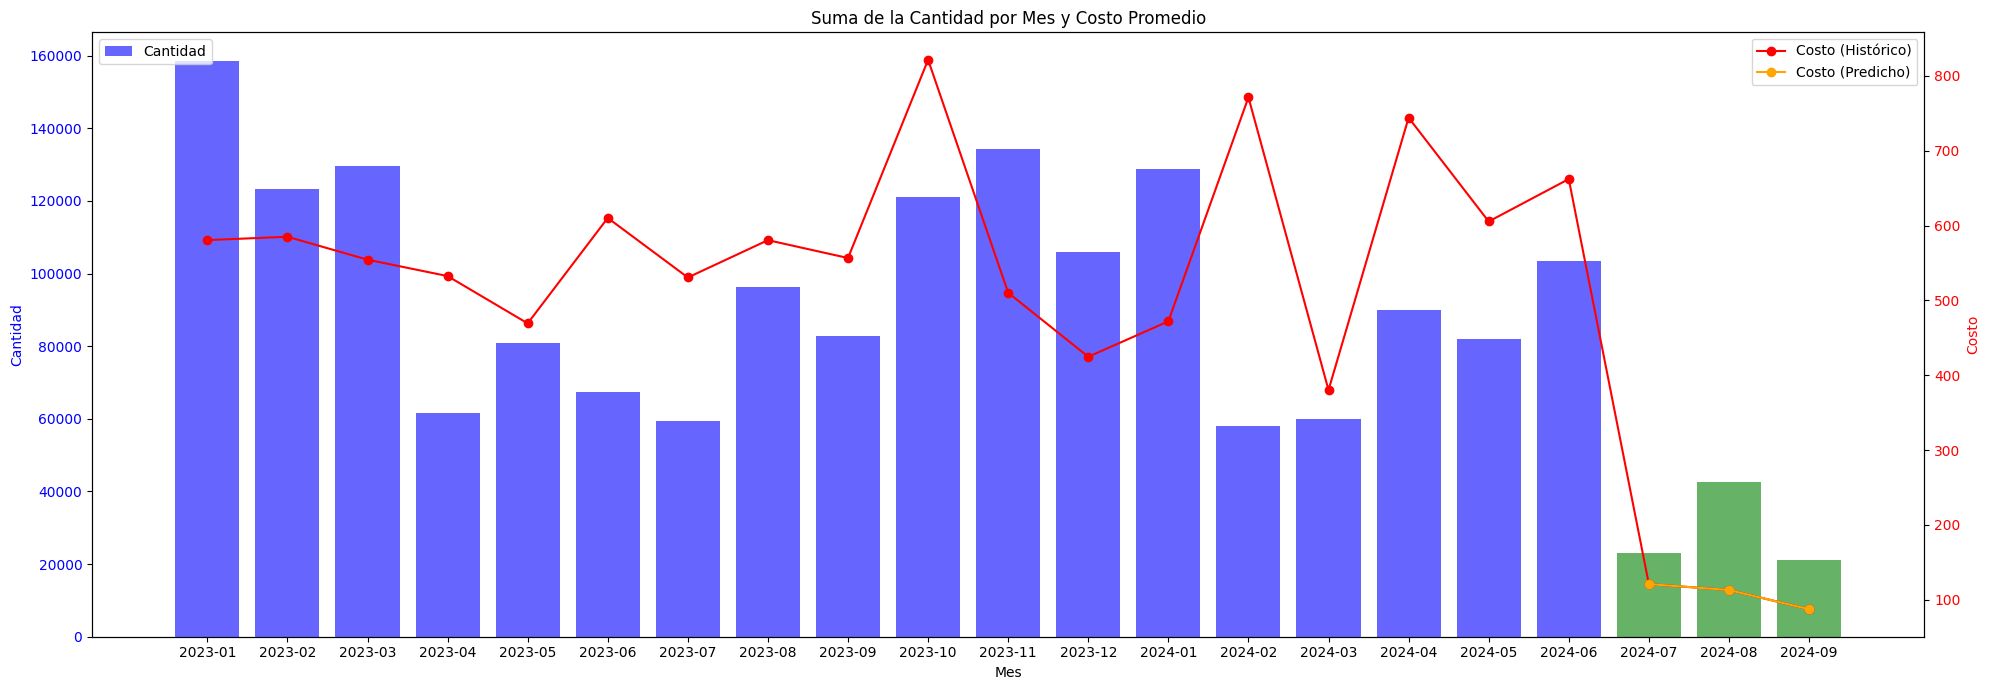

: 

In [226]:
# Agrupar por mes y calcular la suma de la cantidad y el costo promedio
full_datos_combinados['Mes'] = full_datos_combinados['Fecha'].dt.to_period('M')
cantidad_mensual = full_datos_combinados.groupby('Mes')['Cantidad'].sum().reset_index()
costo_mensual = full_datos_combinados.groupby('Mes')['Costo'].mean().reset_index()

# Identificar los meses a partir de julio de 2024 para resaltar
predicted_start = pd.Period('2024-07', freq='M')

# Graficar la cantidad por mes en barras y el costo en líneas
fig, ax1 = plt.subplots(figsize=(20, 7))

# Gráfico de barras para la cantidad
bar_colors = ['b' if mes < predicted_start else 'g' for mes in cantidad_mensual['Mes']]
ax1.bar(cantidad_mensual['Mes'].astype(str), cantidad_mensual['Cantidad'], color=bar_colors, alpha=0.6, label='Cantidad')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Cantidad', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Gráfico de líneas para el costo
ax2 = ax1.twinx()
line_colors = ['r' if mes < predicted_start else 'orange' for mes in costo_mensual['Mes']]
ax2.plot(costo_mensual['Mes'].astype(str), costo_mensual['Costo'], color='r', marker='o', label='Costo (Histórico)')
ax2.plot(costo_mensual[costo_mensual['Mes'] >= predicted_start]['Mes'].astype(str), 
         costo_mensual[costo_mensual['Mes'] >= predicted_start]['Costo'], 
         color='orange', marker='o', label='Costo (Predicho)')
ax2.set_ylabel('Costo', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Título y leyenda
plt.title('Suma de la Cantidad por Mes y Costo Promedio')
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar la gráfica
plt.show()

In [103]:
full_datos_combinados

Sucursal                    Producto      Fecha     Precio  \
0        AGROFACIL           ALLECTUS GR 20 KG 2023-01-03     0.0000   
1        AGROFACIL           ALLECTUS GR 20 KG 2023-01-04     0.0000   
2        AGROFACIL           ALLECTUS GR 20 KG 2023-01-05  1045.2195   
3        AGROFACIL           ALLECTUS GR 20 KG 2023-01-06  1045.2195   
4        AGROFACIL           ALLECTUS GR 20 KG 2023-01-07  1045.2195   
...            ...                         ...        ...        ...   
136305  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-23        NaN   
136306  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-24        NaN   
136307  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-25        NaN   
136308  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-26        NaN   
136309  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-27        NaN   

        Cantidad      Venta   Costo      Mes  
0            0.0     0.0000    0.00  2023-01  
1            0.0     0.0000    0.00  2023-01  
2            1.0  1045.2195  686.32  2023-01  
3            0.0     0.0000    0.00  2023-01  
4            0.0     0.0000    0.00  2023-01  
...          ...        ...     ...      ...  
136305       0.0        NaN    0.00  2024-09  
136306       0.0        NaN    0.00  2024-09  
136307       0.0        NaN    0.00  2024-09  
136308       0.0        NaN    0.00  2024-09  
136309       0.0        NaN    0.00  2024-09  

[136310 rows x 8 columns]

In [109]:
import pandas as pd
import numpy as np

# Cargar el DataFrame combinado
full_datos_combinados = pd.read_excel('full_datos_combinados.xlsx')
full_datos_combinados['Fecha'] = pd.to_datetime(full_datos_combinados['Fecha'])

# Filtrar los datos hasta el último día de junio
ultimo_dia_junio = '2024-06-30'
datos_hasta_junio = full_datos_combinados[full_datos_combinados['Fecha'] <= ultimo_dia_junio]

# Asegurarse de que las columnas relevantes sean numéricas
datos_hasta_junio['Precio'] = pd.to_numeric(datos_hasta_junio['Precio'], errors='coerce')
datos_hasta_junio['Cantidad'] = pd.to_numeric(datos_hasta_junio['Cantidad'], errors='coerce')

# Agrupar los datos por semana
datos_hasta_junio['Semana'] = datos_hasta_junio['Fecha'].dt.to_period('W')

# Calcular la elasticidad para cada combinación de Sucursal y Producto
elasticidades = []

for (sucursal, producto), grupo in datos_hasta_junio.groupby(['Sucursal', 'Producto']):
    grupo_semanal = grupo.groupby('Semana').agg({
        'Cantidad': 'sum',
        'Precio': 'mean'
    }).reset_index()
    
    grupo_semanal = grupo_semanal.sort_values('Semana')
    grupo_semanal['Lag_Cantidad'] = grupo_semanal['Cantidad'].shift(1)
    grupo_semanal['Lag_Precio'] = grupo_semanal['Precio'].shift(1)
    grupo_semanal
    
    grupo_semanal = grupo_semanal.dropna(subset=['Lag_Cantidad', 'Lag_Precio'])

    grupo_semanal['Delta_Q'] = (grupo_semanal['Cantidad'] - grupo_semanal['Lag_Cantidad']) / grupo_semanal['Lag_Cantidad']
    grupo_semanal['Delta_P'] = (grupo_semanal['Precio'] - grupo_semanal['Lag_Precio']) / grupo_semanal['Lag_Precio']

    # Filtrar valores extremos que pueden causar problemas en los cálculos
    grupo_semanal = grupo_semanal.replace([np.inf, -np.inf], np.nan).dropna(subset=['Delta_Q', 'Delta_P'])
    
    # Calcular elasticidad solo si Delta_P es diferente de cero para evitar divisiones por cero
    grupo_semanal = grupo_semanal[grupo_semanal['Delta_P'] != 0]

    if not grupo_semanal.empty:
        elasticidad = (grupo_semanal['Delta_Q'] / grupo_semanal['Delta_P']).mean()
    else:
        elasticidad = np.nan
    
    elasticidades.append({'Sucursal': sucursal, 'Producto': producto, 'Elasticidad': elasticidad})

# Convertir los resultados a un DataFrame
elasticidades_df = pd.DataFrame(elasticidades)

# Guardar los resultados en un archivo Excel
elasticidades_df.to_excel('elasticidades.xlsx', index=False)

# Mostrar los primeros registros del DataFrame de elasticidades
elasticidades_df


Sucursal                    Producto   Elasticidad
0     AGROFACIL           ALLECTUS GR 20 KG -1.919992e+01
1     AGROFACIL           DEMAND DUO 240 ML -8.949647e+01
2     AGROFACIL        FAENA FUERTE 360 LTO  7.274439e+15
3     AGROFACIL      FAENA FUERTE DE 10 LTS           NaN
4     AGROFACIL                  FAENA LTO.  6.130947e+15
..          ...                         ...           ...
210  VILLAHERMO              K-OBIOL 10 LTS           NaN
211  VILLAHERMO   PHOSTOXIN 333 TABS. 1 KG. -2.111871e+01
212  VILLAHERMO        PYBUTHRIN 33 20 LTS.           NaN
213  VILLAHERMO           TERMIDOR C.E. LT. -2.856225e+01
214  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) -6.527778e+00

[215 rows x 3 columns]

In [110]:
import pandas as pd
import numpy as np

# Cargar las predicciones de costos y cantidades
predicciones_costos = pd.read_excel('predicciones_futuras.xlsx')
predicciones_cantidad = pd.read_excel('predicciones_futuras_Cantidad.xlsx')

# Cargar las elasticidades calculadas hasta junio
elasticidades_df = pd.read_excel('elasticidades.xlsx')

# Crear una columna para identificar la combinación única de Sucursal y Producto en predicciones
predicciones_costos['Sucursal_Producto'] = predicciones_costos['Sucursal'] + ' - ' + predicciones_costos['Producto']
predicciones_cantidad['Sucursal_Producto'] = predicciones_cantidad['Sucursal'] + ' - ' + predicciones_cantidad['Producto']

# Combinar las predicciones de costos y cantidades
predicciones = predicciones_costos.merge(predicciones_cantidad, on=['Fecha', 'Sucursal', 'Producto', 'Sucursal_Producto'], suffixes=('_Costo', '_Cantidad'))
predicciones

Fecha    Sucursal                    Producto  Costo  \
0     2024-06-30   AGROFACIL           ALLECTUS GR 20 KG    0.0   
1     2024-07-01   AGROFACIL           ALLECTUS GR 20 KG    0.0   
2     2024-07-02   AGROFACIL           ALLECTUS GR 20 KG    0.0   
3     2024-07-03   AGROFACIL           ALLECTUS GR 20 KG    0.0   
4     2024-07-04   AGROFACIL           ALLECTUS GR 20 KG    0.0   
...          ...         ...                         ...    ...   
19345 2024-09-23  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP)    0.0   
19346 2024-09-24  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP)    0.0   
19347 2024-09-25  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP)    0.0   
19348 2024-09-26  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP)    0.0   
19349 2024-09-27  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP)    0.0   

                             Sucursal_Producto  Cantidad  
0                AGROFACIL - ALLECTUS GR 20 KG         0  
1                AGROFACIL - ALLECTUS GR 20 KG         0  
2                AGROFACIL - ALLECTUS GR 20 KG         0  
3                AGROFACIL - ALLECTUS GR 20 KG         0  
4                AGROFACIL - ALLECTUS GR 20 KG         0  
...                                        ...       ...  
19345  VILLAHERMO - TRAMPA 72MAX DE GOMA (IMP)         0  
19346  VILLAHERMO - TRAMPA 72MAX DE GOMA (IMP)         0  
19347  VILLAHERMO - TRAMPA 72MAX DE GOMA (IMP)         0  
19348  VILLAHERMO - TRAMPA 72MAX DE GOMA (IMP)         0  
19349  VILLAHERMO - TRAMPA 72MAX DE GOMA (IMP)         0  

[19350 rows x 6 columns]

In [154]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Cargar los datos originales y las predicciones
full_datos_combinados = pd.read_excel('full_datos_combinados.xlsx')
predicciones_costos = pd.read_excel('predicciones_futuras.xlsx')
predicciones_cantidad = pd.read_excel('predicciones_futuras_Cantidad.xlsx')
elasticidades_df = pd.read_excel('elasticidades.xlsx')

# Verificar las columnas presentes en los archivos cargados
print(full_datos_combinados.columns)
print(predicciones_costos.columns)
print(predicciones_cantidad.columns)
print(elasticidades_df.columns)

# Asegurarnos de que la columna de precios exista
if 'Precio' not in full_datos_combinados.columns:
    raise KeyError("'Precio' no encontrado en full_datos_combinados")

# Crear una columna para identificar la combinación única de Sucursal y Producto en predicciones
predicciones_costos['Sucursal_Producto'] = predicciones_costos['Sucursal'] + ' - ' + predicciones_costos['Producto']
predicciones_cantidad['Sucursal_Producto'] = predicciones_cantidad['Sucursal'] + ' - ' + predicciones_cantidad['Producto']

# Combinar las predicciones de costos y cantidades
predicciones = predicciones_costos.merge(predicciones_cantidad, on=['Fecha', 'Sucursal', 'Producto', 'Sucursal_Producto'], suffixes=('_Costo', '_Cantidad'))

# Añadir las elasticidades a las predicciones
predicciones = predicciones.merge(elasticidades_df, on=['Sucursal', 'Producto'], how='left')

# Añadir la columna de precio de full_datos_combinados a predicciones
predicciones = predicciones.merge(full_datos_combinados[['Fecha', 'Sucursal', 'Producto', 'Precio']], on=['Fecha', 'Sucursal', 'Producto'], how='left')

# Actualizar la columna Cantidad a 0 donde el Costo es 0 para las fechas futuras
full_datos_combinados['Cantidad'] = np.where((full_datos_combinados['Fecha'] >= pd.to_datetime('2024-06-29')) & (full_datos_combinados['Costo'] == 0),
                                             0,
                                             full_datos_combinados['Cantidad'])

# Actualizar la columna Cantidad a 0 donde el Costo es 0 para las fechas futuras
full_datos_combinados['Costo'] = np.where((full_datos_combinados['Fecha'] >= pd.to_datetime('2024-06-29')) & (full_datos_combinados['Cantidad'] == 0),
                                             0,
                                             full_datos_combinados['Costo'])

# Definir la función de ganancia
def ganancia(precio, costo_unitario, elasticidad, cantidad_inicial, precio_inicial):
    if elasticidad == 0:
        return 0
    cantidad = cantidad_inicial * ((precio / precio_inicial) ** elasticidad)
    costo_total = costo_unitario * cantidad
    return (precio * cantidad) - costo_total

# Optimizar el precio para maximizar la ganancia
def optimizar_precio(row):
    if np.isnan(row['Elasticidad']) or row['Elasticidad'] == 0:
        return np.nan
    cantidad_inicial = row['Cantidad']
    precio_inicial = row['Precio']
    costo_unitario = row['Costo']
    resultado = minimize(lambda p: -ganancia(p, costo_unitario, row['Elasticidad'], cantidad_inicial, precio_inicial), 
                         x0=precio_inicial, bounds=[(0, None)])
    return resultado.x[0] if resultado.success else np.nan

# Aplicar la optimización
predicciones['Precio_Optimo'] = predicciones.apply(optimizar_precio, axis=1)

# Actualizar los precios en el DataFrame original para las fechas futuras
full_datos_combinados['Fecha'] = pd.to_datetime(full_datos_combinados['Fecha'])
full_datos_combinados = full_datos_combinados.merge(predicciones[['Fecha', 'Sucursal', 'Producto', 'Precio_Optimo']], 
                                                    on=['Fecha', 'Sucursal', 'Producto'], 
                                                    how='left')

# Actualizar la columna Precio con Precio_Optimo solo para las fechas futuras
full_datos_combinados['Precio'] = np.where(full_datos_combinados['Fecha'] >= pd.to_datetime('2024-06-29'),
                                           full_datos_combinados['Precio_Optimo'], 
                                           full_datos_combinados['Precio'])

# Llenar los valores de precios vacíos con el último precio no nulo
full_datos_combinados['Precio'] = full_datos_combinados.groupby(['Sucursal', 'Producto'])['Precio'].transform(lambda group: group.ffill())

# Eliminar la columna Precio_Optimo ya que ya hemos actualizado el precio
full_datos_combinados.drop(columns=['Precio_Optimo'], inplace=True)

# Guardar el DataFrame actualizado
full_datos_combinados.to_excel('full_datos_combinados_actualizado_con_precios.xlsx', index=False)

# Mostrar los primeros registros del DataFrame actualizado
print(full_datos_combinados.head())


Index(['Sucursal', 'Producto', 'Fecha', 'Precio', 'Cantidad', 'Venta',
       'Costo'],
      dtype='object')
Index(['Fecha', 'Sucursal', 'Producto', 'Costo'], dtype='object')
Index(['Fecha', 'Sucursal', 'Producto', 'Cantidad'], dtype='object')
Index(['Sucursal', 'Producto', 'Elasticidad'], dtype='object')
    Sucursal           Producto      Fecha     Precio  Cantidad      Venta  \
0  AGROFACIL  ALLECTUS GR 20 KG 2023-01-03  1045.2195       0.0     0.0000   
1  AGROFACIL  ALLECTUS GR 20 KG 2023-01-04  1045.2195       0.0     0.0000   
2  AGROFACIL  ALLECTUS GR 20 KG 2023-01-05  1045.2195       1.0  1045.2195   
3  AGROFACIL  ALLECTUS GR 20 KG 2023-01-06  1045.2195       0.0     0.0000   
4  AGROFACIL  ALLECTUS GR 20 KG 2023-01-07  1045.2195       0.0     0.0000   

    Costo  
0    0.00  
1    0.00  
2  686.32  
3    0.00  
4    0.00  


       Fecha   Sucursal           Producto  Costo  \
0 2024-06-30  AGROFACIL  ALLECTUS GR 20 KG    0.0   
1 2024-07-01  AGROFACIL  ALLECTUS GR 20 KG    0.0   
2 2024-07-02  AGROFACIL  ALLECTUS GR 20 KG    0.0   
3 2024-07-03  AGROFACIL  ALLECTUS GR 20 KG    0.0   
4 2024-07-04  AGROFACIL  ALLECTUS GR 20 KG    0.0   

               Sucursal_Producto  Cantidad  Elasticidad  Precio_Optimo  \
0  AGROFACIL - ALLECTUS GR 20 KG         0   -19.199918            NaN   
1  AGROFACIL - ALLECTUS GR 20 KG         0   -19.199918            NaN   
2  AGROFACIL - ALLECTUS GR 20 KG         0   -19.199918            NaN   
3  AGROFACIL - ALLECTUS GR 20 KG         0   -19.199918            NaN   
4  AGROFACIL - ALLECTUS GR 20 KG         0   -19.199918            NaN   

   Ganancia  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


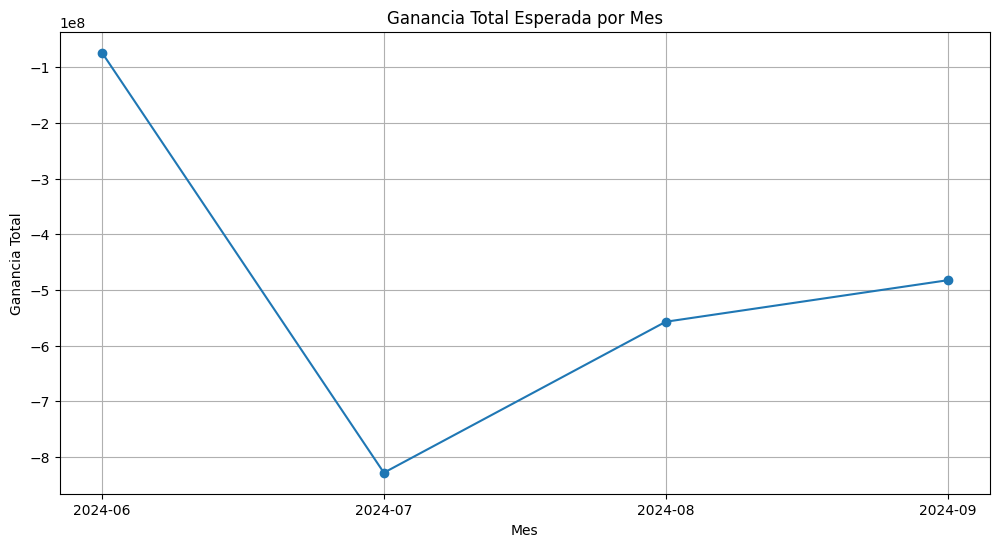

In [135]:
import pandas as pd
import numpy as np

# Cargar las predicciones de costos y cantidades
predicciones_costos = pd.read_excel('predicciones_futuras.xlsx')
predicciones_cantidad = pd.read_excel('predicciones_futuras_Cantidad.xlsx')

# Cargar las elasticidades calculadas hasta junio
elasticidades_df = pd.read_excel('elasticidades.xlsx')

# Crear una columna para identificar la combinación única de Sucursal y Producto en predicciones
predicciones_costos['Sucursal_Producto'] = predicciones_costos['Sucursal'] + ' - ' + predicciones_costos['Producto']
predicciones_cantidad['Sucursal_Producto'] = predicciones_cantidad['Sucursal'] + ' - ' + predicciones_cantidad['Producto']

# Combinar las predicciones de costos y cantidades
predicciones = predicciones_costos.merge(predicciones_cantidad, on=['Fecha', 'Sucursal', 'Producto', 'Sucursal_Producto'], suffixes=('_Costo', '_Cantidad'))

# Añadir las elasticidades a las predicciones
predicciones = predicciones.merge(elasticidades_df, on=['Sucursal', 'Producto'], how='left')

# Calcular el precio óptimo diario a partir de julio
predicciones['Precio_Optimo'] = np.nan

for index, row in predicciones.iterrows():
    if not np.isnan(row['Elasticidad']):
        if row['Elasticidad'] == 0 or row['Cantidad'] == 0:
            predicciones.at[index, 'Precio_Optimo'] = np.nan
        else:
            predicciones.at[index, 'Precio_Optimo'] = (row['Costo'] / row['Cantidad']) / (1 + (1 / row['Elasticidad']))

# Establecer cantidad a 0 si el costo es 0
predicciones['Cantidad'] = predicciones.apply(lambda row: 0 if row['Costo'] == 0 else row['Cantidad'], axis=1)

# Calcular las ganancias esperadas
predicciones['Ganancia'] = (predicciones['Precio_Optimo'] - predicciones['Costo']) * predicciones['Cantidad']

# Guardar los resultados en un archivo Excel
predicciones.to_excel('predicciones_con_precio_optimo.xlsx', index=False)

# Mostrar los primeros registros del DataFrame final
print(predicciones.head())

# Agrupar y resumir los resultados para visualizar la ganancia total esperada por mes
predicciones['Mes'] = predicciones['Fecha'].dt.to_period('M')
resumen_ganancias = predicciones.groupby('Mes')['Ganancia'].sum().reset_index()

# Graficar las ganancias esperadas por mes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(resumen_ganancias['Mes'].astype(str), resumen_ganancias['Ganancia'], marker='o')
plt.title('Ganancia Total Esperada por Mes')
plt.xlabel('Mes')
plt.ylabel('Ganancia Total')
plt.grid(True)
plt.show()


In [139]:
resumen_ganancias

Mes      Ganancia
0  2024-06 -7.379234e+07
1  2024-07 -8.283114e+08
2  2024-08 -5.571158e+08
3  2024-09 -4.825345e+08

In [136]:
full_datos_combinados = full_datos_combinados.sort_values(by=['Sucursal', 'Producto', 'Fecha'])

In [137]:
# Combinar los datos de full_datos_combinados con las predicciones para actualizar el precio
full_datos_combinados = full_datos_combinados.merge(predicciones[['Fecha', 'Sucursal', 'Producto', 'Precio_Optimo']], 
                                                    on=['Fecha', 'Sucursal', 'Producto'], 
                                                    how='left')

In [138]:
full_datos_combinados

Sucursal                    Producto      Fecha     Precio  \
0        AGROFACIL           ALLECTUS GR 20 KG 2023-01-03  1045.2195   
1        AGROFACIL           ALLECTUS GR 20 KG 2023-01-04  1045.2195   
2        AGROFACIL           ALLECTUS GR 20 KG 2023-01-05  1045.2195   
3        AGROFACIL           ALLECTUS GR 20 KG 2023-01-06  1045.2195   
4        AGROFACIL           ALLECTUS GR 20 KG 2023-01-07  1045.2195   
...            ...                         ...        ...        ...   
136305  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-23        NaN   
136306  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-24        NaN   
136307  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-25        NaN   
136308  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-26        NaN   
136309  VILLAHERMO  TRAMPA 72MAX DE GOMA (IMP) 2024-09-27        NaN   

        Cantidad      Venta   Costo  Precio_Optimo  
0            0.0     0.0000    0.00            NaN  
1            0.0     0.0000    0.00            NaN  
2            1.0  1045.2195  686.32            NaN  
3            0.0     0.0000    0.00            NaN  
4            0.0     0.0000    0.00            NaN  
...          ...        ...     ...            ...  
136305       0.0        NaN    0.00            NaN  
136306       0.0        NaN    0.00            NaN  
136307       0.0        NaN    0.00            NaN  
136308       0.0        NaN    0.00            NaN  
136309       0.0        NaN    0.00            NaN  

[136310 rows x 8 columns]

In [134]:
# Actualizar la columna Precio con Precio_Optimo solo para las fechas futuras
full_datos_combinados['Precio'] = np.where(full_datos_combinados['Fecha'] >= pd.to_datetime('2024-06-29'),
                                           full_datos_combinados['Precio_Optimo'], 
                                           full_datos_combinados['Precio'])

# Eliminar la columna Precio_Optimo ya que ya hemos actualizado el precio
full_datos_combinados.drop(columns=['Precio_Optimo'], inplace=True)

# Guardar el DataFrame actualizado
full_datos_combinados.to_excel('full_datos_combinados_actualizado.xlsx', index=False)

In [124]:
# Crear una columna para identificar la combinación única de Sucursal y Producto
full_datos_combinados['Sucursal_Producto'] = full_datos_combinados['Sucursal'] + ' - ' + full_datos_combinados['Producto']

# Reemplazar precios cero con el último precio > 0 de la misma sucursal y producto
def reemplazar_precio_cero(grupo):
    ultimo_precio = np.nan
    for idx in grupo.index:
        if grupo.at[idx, 'Precio'] > 0:
            ultimo_precio = grupo.at[idx, 'Precio']
        elif grupo.at[idx, 'Precio'] == 0 and not np.isnan(ultimo_precio):
            grupo.at[idx, 'Precio'] = ultimo_precio
    return grupo

full_datos_combinados = full_datos_combinados.groupby('Sucursal_Producto').apply(reemplazar_precio_cero)

# Eliminar la columna Sucursal_Producto ya que era solo para facilitar el procesamiento
full_datos_combinados.drop(columns=['Sucursal_Producto'], inplace=True)

# Guardar el DataFrame actualizado
full_datos_combinados.to_excel('full_datos_combinados_actualizado_con_precios.xlsx', index=False)

# Mostrar los primeros registros del DataFrame actualizado
print(full_datos_combinados.head())


                                  Sucursal           Producto      Fecha  \
Sucursal_Producto                                                          
AGROFACIL - ALLECTUS GR 20 KG 0  AGROFACIL  ALLECTUS GR 20 KG 2023-01-03   
                              1  AGROFACIL  ALLECTUS GR 20 KG 2023-01-04   
                              2  AGROFACIL  ALLECTUS GR 20 KG 2023-01-05   
                              3  AGROFACIL  ALLECTUS GR 20 KG 2023-01-06   
                              4  AGROFACIL  ALLECTUS GR 20 KG 2023-01-07   

                                    Precio  Cantidad      Venta   Costo  
Sucursal_Producto                                                        
AGROFACIL - ALLECTUS GR 20 KG 0  1045.2195       0.0     0.0000    0.00  
                              1  1045.2195       0.0     0.0000    0.00  
                              2  1045.2195       1.0  1045.2195  686.32  
                              3  1045.2195       0.0     0.0000    0.00  
                       